### Análise de sentimentos dos comentários em vídeos do YouTube

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from googletrans import Translator
# from sklearn.metrics import accuracy_score

pd.options.mode.chained_assignment = None

#### Vamos iniciar lendo a base coletada

In [16]:
df = pd.read_csv('result.csv', sep=';', encoding='UTF-8')
df.rename(columns={'Comentarios': 'texto-pt'}, inplace=True)
df.head(5)

,index,texto-pt
0,0,Em pleno 2015 do nada ativou a Siri aqui no me...
1,1,Ainda vale compensa comprar o 1
2,2,Perda de dinheiro
3,3,Isso é a prova de agua
4,4,"apple e apple,produto top"


#### Traduzir texto para uma amostra mais precisa

In [17]:
# traduzir para o ingles onde o vetorizador possa trabalhar melhor
tradutor = Translator()
def traduzir_texto(texto):
    return tradutor.translate(texto, dest='en').text  # en = inglês

df['texto-en'] = df['texto-pt'].apply(traduzir_texto)
df.head(4)

,index,texto-pt,texto-en
0,0,Em pleno 2015 do nada ativou a Siri aqui no me...,In the middle of 2015 out of nowhere activated...
1,1,Ainda vale compensa comprar o 1,It is still worth it to buy the 1
2,2,Perda de dinheiro,Loss of money
3,3,Isso é a prova de agua,This is waterproof


#### Limpando o dataset *(base de dados)*

In [18]:
# remover valores em branco
df.dropna(subset=['texto-en'])

df['texto-en'] = df['texto-en'].str.lower()

# Função para remover emojis do texto
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Símbolos e pictogramas
        "\U0001F680-\U0001F6FF"  # Símbolos de transporte e mapas
        "\U0001F1E0-\U0001F1FF"  # Bandeiras (iOS)
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)
df['texto-en'] = df['texto-en'].apply(remove_emojis)

# remover pontuação e caractere especial do texto
df['texto-en'] = df['texto-en'].str.replace(r'[^A-Za-z0-9 ]+', '', regex=True)

df.head(3)

,index,texto-pt,texto-en
0,0,Em pleno 2015 do nada ativou a Siri aqui no me...,in the middle of 2015 out of nowhere activated...
1,1,Ainda vale compensa comprar o 1,it is still worth it to buy the 1
2,2,Perda de dinheiro,loss of money


##### Stopwords

In [19]:
# Função para remover stopwords(palavras indesejadas) com base no idioma
nltk.download('stopwords', quiet=True)

def remover_stopwords(texto, idioma='portuguese'):
    # Obtém as stopwords do idioma escolhido
    stopwords_idioma = set(stopwords.words(idioma))
    palavras = texto.split()
    resultado = [palavra for palavra in palavras if palavra.lower() not in stopwords_idioma]
    return ' '.join(resultado)


df['texto_pt_limpo'] = df['texto-pt'].apply(remover_stopwords, idioma='portuguese')
df['texto-en'] = df['texto-en'].apply(remover_stopwords, idioma='english')

print(df[['texto-pt', 'texto_pt_limpo']].tail(2))

                     texto-pt     texto_pt_limpo
249        por isso eu gostei             gostei
250  Resumindo, isso é inútil  Resumindo, inútil


### Iniciar o VADER para criar o alvo
Cria uma categorização com um modelo do NLTK VADER <br>
para definir a situação do texto *(positivo, negativo e neutro)*



In [20]:
# Iniciar o VADER 
vader = SentimentIntensityAnalyzer()

df['sentiment_scores'] = df['texto-en'].apply(vader.polarity_scores)

# Extrair o compound e categorize sentiment
df['compound'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment'] = df['compound'].apply(lambda c: 'positivo' if c >= 0.05 else ('negativo' if c <= -0.05 else 'neutro'))


#### Alvo pronto, vamos conferir a amostra

In [22]:
print(df[['texto-pt','sentiment']].head(5))

                                            texto-pt sentiment
0  Em pleno 2015 do nada ativou a Siri aqui no me...    neutro
1                   Ainda vale compensa comprar o 1   positivo
2                                  Perda de dinheiro  negativo
3                             Isso é a prova de agua    neutro
4                          apple e apple,produto top  positivo


<br>
<br>
<br>
Contagem acumulativa por sentimento

In [23]:
df['sentiment'].value_counts()

sentiment
neutro      125
positivo     87
negativo     39
Name: count, dtype: int64

Separando base
<br>
<br>
Positivo x Negativo

In [24]:
df_positivo = df[df['sentiment'] == 'positivo']
df_negativo = df[df['sentiment'] == 'negativo']
df_positivo.head(4)

,index,texto-pt,texto-en,texto_pt_limpo,sentiment_scores,compound,sentiment
1,1,Ainda vale compensa comprar o 1,still worth buy 1,Ainda vale compensa comprar 1,"{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp...",0.2263,positivo
4,4,"apple e apple,produto top",apple apple top product,"apple apple,produto top","{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...",0.2023,positivo
6,6,"Ganhei o meu no natal de 2015, sou mega apaixo...",mine christmas 2015 im mega love himi use ever...,"Ganhei natal 2015, mega apaixonada ele. Uso to...","{'neg': 0.0, 'neu': 0.648, 'pos': 0.352, 'comp...",0.8834,positivo
11,11,"Dezembro de 2021, comprei meu series 7 haha",december 2021 bought series 7 haha,"Dezembro 2021, comprei series 7 haha","{'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'comp...",0.4588,positivo


Nuvem de palavras mais utilizadas na nossa coleta

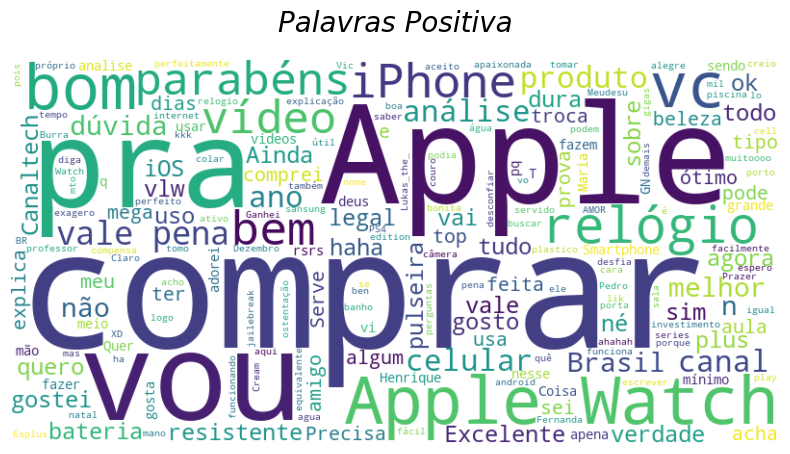

In [25]:
def nuvem_palavras(df_entrada, coluna_entrada, titulo):
    texto_completo = " ".join(df_entrada[coluna_entrada])
    # Gerar a nuvem de palavras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_completo)
    # Plotar a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Desativa os eixos
    plt.title(titulo, fontsize=20, pad=20, style='italic')
    plt.show()


nuvem_palavras(df_positivo, 'texto_pt_limpo', titulo='Palavras Positiva')

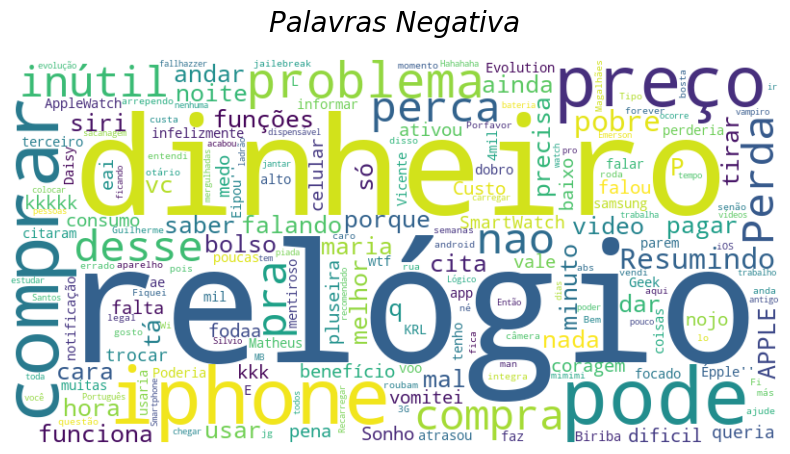

In [26]:
nuvem_palavras(df_negativo, 'texto_pt_limpo', titulo='Palavras Negativa')

#### Pronto! Conseguimos chegar em alguns objetivos 🎉🤩 <br>

Classificação do texto (positivo, negativo e neutro)<br>
Resultado de palavras mais utilizadas
<br>
<br>
Definitivamente há espaço para melhorias. Mas, tenha em mente que obtivemos essa pontuação sem fazer nenhuma alteração no VADER